In [2]:
import requests
from bs4 import BeautifulSoup
import numpy as np
# import re

In [3]:
# def transform_html_to_data(soup):
#     apartments_data = soup.find_all('class="listingCard"')
#     apartments = []
#     for apartment in apartments_data:
#         price = apartment.find('span', class_='andes-money-amount__fraction').text
#         price = int(price.replace(".", ""))
#         address = apartment.find(class_='ui-search-item__group__element ui-search-item__location shops__items-group-details').text
#         space_information = apartment.find(class_='ui-search-item__group ui-search-item__group--attributes shops__items-group').text
#         if space_information:
#             size = re.search(r'(\d+) m', space_information)
#             if size:
#                 size = int(size.group(1))
#             rooms = re.search(r'(\d+) dormitorio', space_information)
#             if rooms:
#                 rooms = int(rooms.group(1))
#         data = {'price (CLP)': price, 'rooms': rooms, 'size (m2)': size, 'address': address}
#         apartments.append(data)
#
#     return apartments



In [4]:
def transform_html_to_data(html):
    apartments_data = html.find_all(class_="lc-dataWrapper")
    apartments = []
    for apartment in apartments_data:
        # currency, price
        line = apartment.find('div', class_="lc-price").text
        line = line.split(' ')
        if line[0] != '':
            continue
        currency = line[1]
        price = int(''.join(line[2]).replace('.', ''))
        # bedroom, bath, m2,
        line = apartment.find('div', class_="lc-typologyTag").contents
        if len(line) != 3: 
            continue
        bedroom = line[0].text.split(' ')
        bath = line[1].text.split(' ')
        m2 = line[2].text.split(' ')
        try:
            bedroom = int(bedroom[0])
        except ValueError:
            continue
        bath = int(bath[0])
        m2 = int(m2[0])
        # zone, region
        line = apartment.find('strong', class_="lc-location").text
        line = line.split(', ')
        if len(line) == 0: 
            continue
        zone = line[0]
        region = line[1]
        data = {'currency': currency, 'price': price, 
                'bedroom': bedroom, 'bath': bath, 'm2': m2,
                'zone': zone, 'region': region}
        apartments.append(data)
    return apartments


In [5]:
pages = np.arange(1, 51)
apartments_list = []
for page in pages:
    url = f'https://www.infocasas.com.uy/venta/inmuebles/pagina{page}'
    headers = {'User-Agent': 'Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:109.0) Gecko/20100101 Firefox/115.0'}
    response = requests.request("GET", url, headers=headers, data={})
    soup = BeautifulSoup(response.content)
    # apartments_list += [soup]
    apartments_list += transform_html_to_data(soup)

len(apartments_list)

886

## Transformamos los datos en un DataFrame

In [19]:
import pandas as pd
df = pd.DataFrame(apartments_list)
df.shape

(886, 7)

## Data Cleaning
### Filtramos por 'bedrooms'

In [7]:
df = df[df['bedroom'] < 6]
df.value_counts("bedroom")

bedroom
3    287
2    248
1    150
4    142
5     50
dtype: int64

In [8]:
# df.to_json('../data/inmuebles_en_venta.json')

### Filtramos por 'currency'

In [9]:
df = df[df['currency'] == 'U$S']
df.value_counts('currency')

currency
U$S    876
dtype: int64

### Filtramos por price

<Axes: xlabel='bedroom', ylabel='price'>

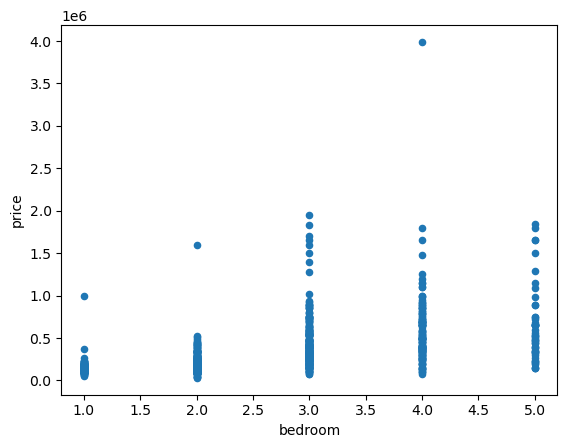

In [10]:
df.plot.scatter(y='price', x='bedroom')

In [11]:
df = df[df['price'] < 2500000]
df.shape

(875, 7)

In [12]:
df.value_counts('region')

region
Montevideo    620
Maldonado     169
Canelones      84
Rocha           1
San José        1
dtype: int64

In [13]:
df.value_counts('bedroom')

bedroom
3    287
2    248
1    149
4    141
5     50
dtype: int64

In [1]:
df.shape

NameError: name 'df' is not defined